# EDA for Amy Research Question 1

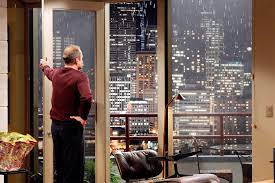

In [2]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px



from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
# pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
# Loading the dataset:
basic_king = pd.read_csv('data/King_County_House_prices_dataset.csv')

# Get info about the variables
basic_king.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Changing the date to yyyy/mm which will make it easier to have a look at the change over time later on
import datetime

basic_king['date'] = pd.to_datetime(basic_king.date)
basic_king['month_sold'] = basic_king['date'].dt.to_period('M')
basic_king['month_sold'] = basic_king['month_sold'].astype(str)

In [5]:
# Create new columns via calculation:

# df.eval('age = nr_rings + 1.5', inplace = True)

# Drop columns
# df.drop('nr_rings', inplace=True, axis=1) 


### Load airport data to enhance the maps

In [6]:
# Import airport dataset:

df_airports = pd.read_csv("data/airports.csv")

# Extract only airports in washington state
df_airports_wa = df_airports[df_airports['state'] == "WA"]
df_airports_wa.rename(columns={'latitude': 'lat', 'longitude':'long'}, inplace=True)
df_airports_wa.head()

iata                            name           city state country  \
84   0S7                   Dorothy Scott       Oroville    WA     USA   
85   0S9  Jefferson County International  Port Townsend    WA     USA   
191  1S0                   Pierce County       Puyallup    WA     USA   
193  1S5             Sunnyside Municipal      Sunnyside    WA     USA   
280  2S1                Vashon Municipal         Vashon    WA     USA   

           lat        long  
84   48.958965 -119.411962  
85   48.049814 -122.801279  
191  47.103917 -122.287194  
193  46.327631 -119.970596  
280  47.458153 -122.477351

### Build dataframe with location of FBI Seattle

The location of FBI Seattle is included to enhance the map information later on.

In [7]:
# Include FBI location:

fbi = pd.DataFrame({
    'name': ['FBI'],
    'lat': [47.60679669902346],
    'long': [-122.3347287439417]
})

### Enlarge dataset with new columns which help to identify the renovation status

In [9]:
# Rebuild yr_renovated column: yr_ren_new is yr_built when 0 in yr_renovated
# ren_unknown is 1 when NaN

basic_king['yr_ren_new'] = np.where(basic_king['yr_renovated'] >= basic_king['yr_built'],basic_king['yr_renovated'], basic_king['yr_built']).astype(int)
basic_king['ren_unknown']= np.where(basic_king['yr_renovated'].isna(), 1,0)
basic_king['water_str'] = basic_king['waterfront'].astype(str)

# Label top 10% of all houses based on price

basic_king["10bins"] = pd.qcut(basic_king['price'], q=10)

bin_labels_10 = ['top100','top90', 'top80', 'top70', 'top60', 'top50', 'top40', 'top30', 'top20', 'top10']
basic_king['quantile_name'] = pd.qcut(basic_king['price'],
                              q=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                              labels=bin_labels_10)

# sns.countplot(x='10bins', data=basic_king, color='steelblue')

<function matplotlib.pyplot.show(close=None, block=None)>

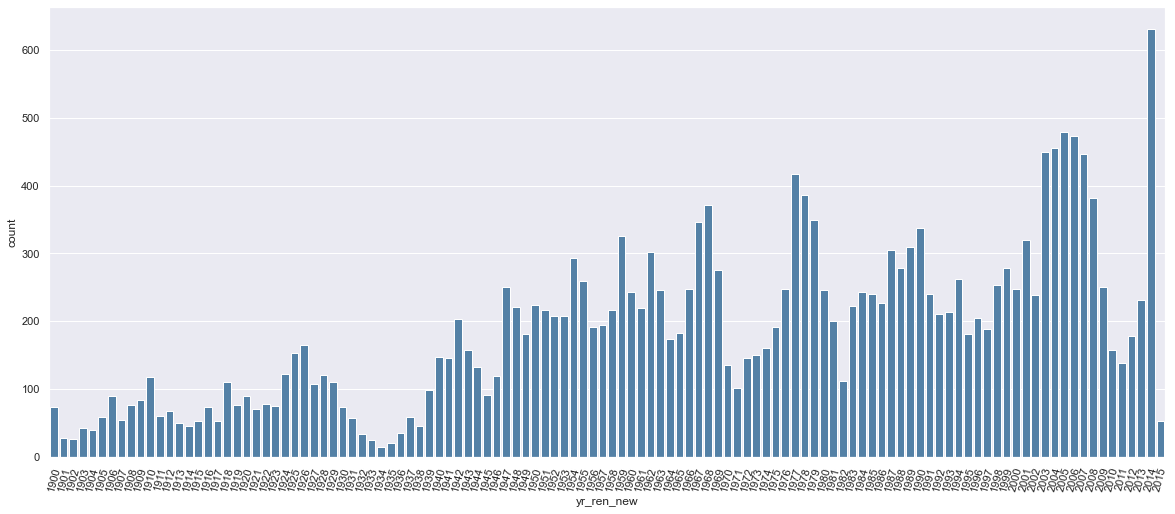

In [10]:
# Countplot of yr_ren_new

sns.set(rc={'figure.figsize':(20.0,8.27)})
sns.countplot(x='yr_ren_new', data=basic_king, color= 'steelblue')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation = 75)
plt.show


In [12]:
# sns.pairplot(basic_king)

In [13]:
# Basic map with all houses included, different colors show if house is on waterfront or not.

# fig = px.scatter_mapbox(basic_king, lat="lat", lon="long", hover_name="id", hover_data=["price", "sqft_living"],
#                         color_discrete_sequence=["red"], zoom=1, width=800, height=600)
fig = px.scatter_mapbox(basic_king, lat="lat", lon="long", hover_name="id", hover_data=["price", "sqft_living"],
                        color = 'water_str', zoom=8, width=800, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":10,"t":10,"l":10,"b":10})
fig.show()

In [14]:
# Drop all houses where we know about renovation:

basic_king_known = basic_king.drop(basic_king[basic_king['ren_unknown'] == 1 ].index)

# Drop all houses which were renovated in the last 10 years:

basic_king_known_10 = basic_king_known.drop(basic_king_known[basic_king_known['yr_ren_new'] > (basic_king_known.yr_ren_new.max()-10) ].index)


In [15]:
basic_king_known_10.shape

(15296, 27)

In [16]:
# Plot houses which were not renovated in the last 10 years:

fig = px.scatter_mapbox(basic_king_known_10, lat="lat", lon="long", hover_name="id", hover_data=["price", "sqft_living"],
                        color = 'water_str', zoom=8, width=800, height=600)
fig2 = px.scatter_mapbox(df_airports_wa, lat='lat', lon= 'long', color_discrete_sequence=["blue"], hover_name='iata')
fig3 = px.scatter_mapbox(fbi, lat='lat', lon='long', color_discrete_sequence=["red"], hover_name='name')
fig2.update_traces(marker={'size': 10})
fig3.update_traces(marker={'size': 15})
fig.add_trace(fig2.data[0])
fig.add_trace(fig3.data[0])
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":10,"t":10,"l":10,"b":10})
fig.show()


In [17]:
# Concat "mafia house" data and airport data:

house_notren_airports = pd.concat([df_airports_wa, basic_king_known_10], axis=0)
house_notren_airports['airport'] = np.where(house_notren_airports['iata'].isna(),False, True)

In [18]:
# Plotting not renovated houses in the last 10 years and airports:

fig = px.scatter_mapbox(house_notren_airports, lat="lat", lon="long", hover_name="id", hover_data=["price", "sqft_living", "name"],
                        color = 'airport', zoom=8, width=800, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":10,"t":10,"l":10,"b":10})
fig.show()

## Get an idea about distributions

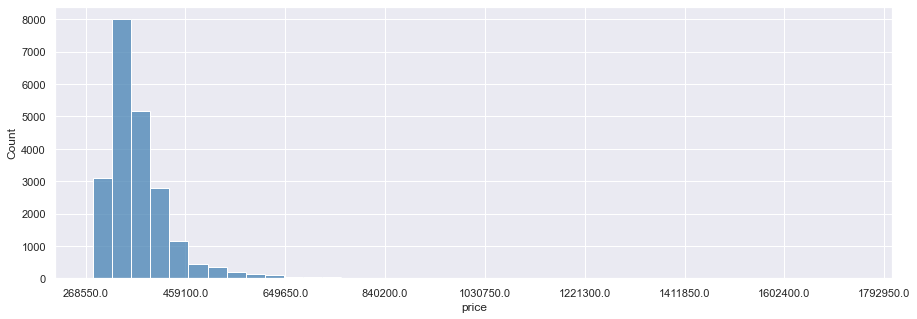

In [19]:
# Price Histogram

sns.set(rc={'figure.figsize':(15.0,5)})

bins = np.histogram_bin_edges(basic_king['price'], bins=40)
sns.histplot(basic_king['price'], bins=bins, color='steelblue').set_xticklabels(bins)

  
plt.show()

[Text(0.5, 1.0, 'Price Histogram')]

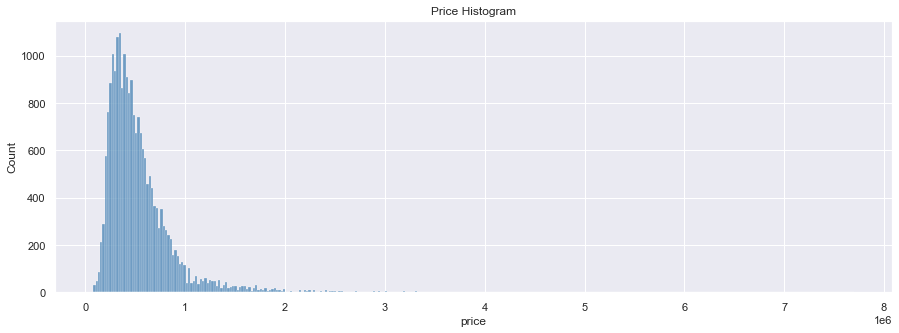

In [20]:
sns.histplot(basic_king['price'], color='steelblue').set(title='Price Histogram')

In [21]:
basic_king.price.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

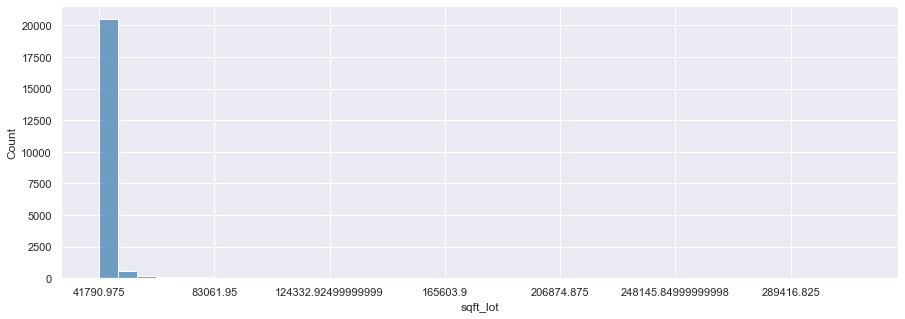

In [22]:
# sqf_lot Histogram

sns.set(rc={'figure.figsize':(15.0,5)})

bins = np.histogram_bin_edges(basic_king['sqft_lot'], bins=40)
sns.histplot(basic_king['sqft_lot'], bins=bins, color='steelblue').set_xticklabels(bins)

  
plt.show()

# # Check for (diverse) land lots:
# basic_king_lot = basic_king[(basic_king['sqft_lot'] <= 150000) & (basic_king['sqft_lot'] >= 110)]

# bins = np.histogram_bin_edges(basic_king_lot['sqft_lot'], bins=100)
# sns.histplot(basic_king_lot['sqft_lot'], bins=bins, color='steelblue').set_xticklabels(bins)

  
# plt.show()

[Text(0.5, 1.0, 'SQFT Land Lot Histogram')]

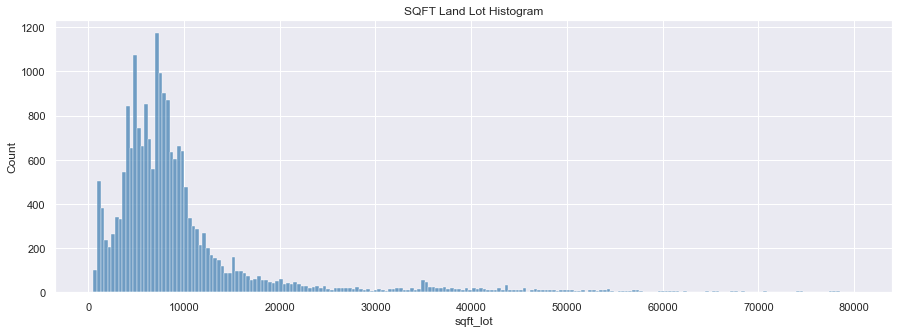

In [23]:
# Reduce dataset to smaller lots (<= 80,000)

basic_king_lot = basic_king[(basic_king['sqft_lot'] <= 80000)]


sns.histplot(basic_king_lot['sqft_lot'], color='steelblue').set(title='SQFT Land Lot Histogram')

In [24]:
basic_king.sqft_lot.describe()

count    2.159700e+04
mean     1.509941e+04
std      4.141264e+04
min      5.200000e+02
25%      5.040000e+03
50%      7.618000e+03
75%      1.068500e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

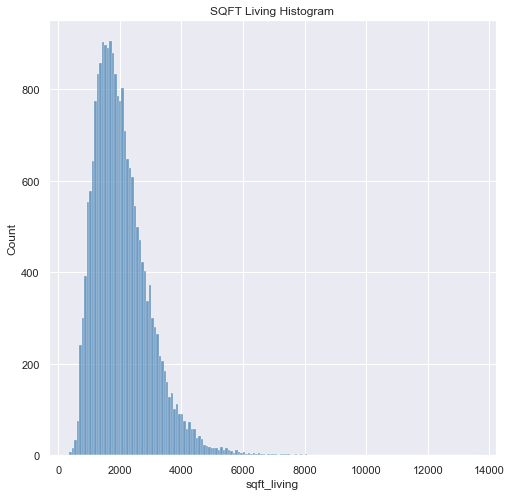

In [41]:
# Plot sqft_living to find medium sized houses 

sns.set(rc={'figure.figsize':(8.0,8)})

# bins = np.histogram_bin_edges(basic_king['sqft_living'], bins=200)
# sns.histplot(basic_king['sqft_living'], bins=bins, color='steelblue').set_xticklabels(bins)

sns.histplot(basic_king['sqft_living'], color='steelblue').set(title='SQFT Living Histogram')

plt.show

In [26]:
basic_king.sqft_living.describe()

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

In [27]:
basic_king.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month_sold',
       'yr_ren_new', 'ren_unknown', 'water_str', '10bins', 'quantile_name'],
      dtype='object')

### Filter dataset to Defcon 3: Medium risk

In [28]:
# Reduce dataset to defcon3
# Medium - high prices (298k - 1 Mio)
# High standard (grade >= 9 ) https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r
# Condition >= 4
# Medium - larger lot sizes
# Access to waterfront
# Near airport


defcon3 = basic_king_known_10[(basic_king_known_10['price'] <= 1000000) & (basic_king_known_10['price'] >= 298000)]
defcon3 = defcon3[(defcon3['grade'] >= 9)]
defcon3 = defcon3[(defcon3['condition'] >= 4)]


# print(defcon3.condition.value_counts())
# print(defcon3.water_str.value_counts())
# print(defcon3.sqft_lot.describe())

<function matplotlib.pyplot.show(close=None, block=None)>

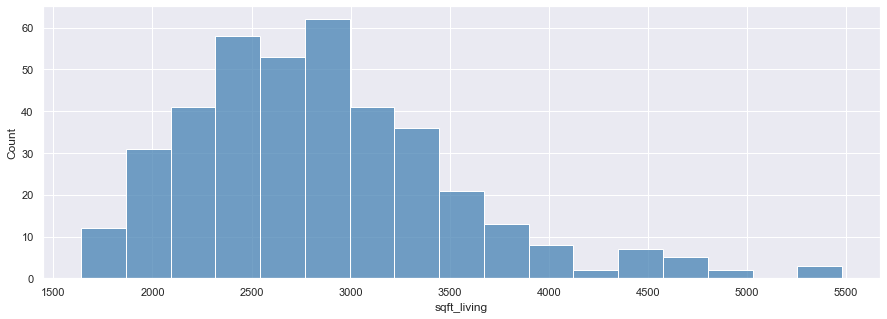

In [29]:
# Plot sqft_living to find medium sized houses 
 
sns.histplot(defcon3['sqft_living'], color='steelblue')

plt.show

In [43]:
# Plot defcon3 houses:

fig = px.scatter_mapbox(defcon3, lat="lat", lon="long", hover_name="id", hover_data=["price", "sqft_living", "sqft_lot"],
                        color = 'water_str', zoom=8, width=800, height=600)
fig2 = px.scatter_mapbox(df_airports_wa, lat='lat', lon= 'long', color_discrete_sequence=["darkmagenta"], hover_name='name')
fig3 = px.scatter_mapbox(fbi, lat='lat', lon='long', color_discrete_sequence=["red"], hover_name='name')
fig2.update_traces(marker={'size': 10})
fig3.update_traces(marker={'size': 15})
fig.add_trace(fig2.data[0])
fig.add_trace(fig3.data[0])
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":10,"t":10,"l":10,"b":10})
fig.show()

### Recommended defcon3 Houses

The following houses were selected for Amy if she is in defcon3 (medium risk):

No. 1: 
- on island
- near airport
- at waterfront
- lat=47.3844, lon=-122.438
- 8166 SW 246th St, Vashon, WA 98070, USA
- https://goo.gl/maps/J8YkczDTqXoszLkh7
- defcon3[defcon3['id'] == 2122039094]

No. 2:
- on island
- near airport
- at waterfront
- lat=47.4, lon=-122.42
- 6908 SW Maury Park Rd, Vashon, WA 98070, USA
- https://goo.gl/maps/QKtpWaoZuibGd3JQ7
- defcon3[defcon3['id'] == 5215200050]

No. 3:
- near center
- near airport
- at waterfront
- lat=47.4536, lon=-122376
- 16747 Maplewild Ave SW, Burien, WA 98166, USA
- https://goo.gl/maps/VParbDxrmK44WSnk9
- defcon3[defcon3['id'] == 2623039082]


### Filter dataset to Defcon 2: Medium - high risk

In [31]:
# Reduce dataset to defcon2
# Medium - prices (298k - 550k)
# Medium - high standard (grade >= 7 ) https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r
# Condition >= 3
# Medium lot sizes
# Access to waterfront preferred
# Location: outskirt but not outback
# Near airport

defcon2 = basic_king_known_10[(basic_king_known_10['price'] <= 600000) & (basic_king_known_10['price'] >= 298000)]
defcon2 = defcon2[(defcon2['grade'] >= 8)]
defcon2 = defcon2[(defcon2['condition'] >= 3)]
defcon2 = defcon2[(defcon2['sqft_lot'] <= 9000) & (defcon2['sqft_lot'] >= 3000)]


print(defcon2.condition.value_counts())
print(defcon2.water_str.value_counts())
print(defcon2.sqft_lot.describe())

3    1064
4     226
5      36
Name: condition, dtype: int64
0.0    1184
nan     141
1.0       1
Name: water_str, dtype: int64
count    1326.000000
mean     6545.221719
std      1581.540358
min      3000.000000
25%      5146.750000
50%      6977.500000
75%      7858.500000
max      9000.000000
Name: sqft_lot, dtype: float64


In [48]:
# Plot defcon2 houses:

fig = px.scatter_mapbox(defcon2, lat="lat", lon="long", hover_name="id", hover_data=["price", "sqft_living", "sqft_lot", 'condition', 'grade'],
                        color = 'water_str', zoom=8, width=800, height=600)
fig2 = px.scatter_mapbox(df_airports_wa, lat='lat', lon= 'long', color_discrete_sequence=["darkmagenta"], hover_name='name')
fig3 = px.scatter_mapbox(fbi, lat='lat', lon='long', color_discrete_sequence=["red"], hover_name='name')
fig2.update_traces(marker={'size': 15})
fig3.update_traces(marker={'size': 15})
fig.add_trace(fig2.data[0])
fig.add_trace(fig3.data[0])
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":10,"t":10,"l":10,"b":10})
fig.show()

In [33]:
defcon2[defcon2['id'] == 8564700240]

id       date     price  bedrooms  bathrooms  sqft_living  \
10698  8564700240 2014-10-17  575000.0         3        2.5         2610   

       sqft_lot  floors  waterfront  view  ...      lat     long  \
10698      7301     2.0         0.0   0.0  ...  47.7614 -122.139   

       sqft_living15 sqft_lot15  month_sold  yr_ren_new  ren_unknown  \
10698           2460       7181     2014-10        2004            0   

       water_str                10bins  quantile_name  
10698        0.0  (519000.0, 595000.0]          top40  

[1 rows x 27 columns]

### Recommended defcon2 Houses

The following houses were selected for Amy if she is in defcon2 (medium - high risk):

No. 1: 
- outskirt
- far away from FBI
- near airport
- near forest (to hide)
- near highway
- lat=47.3124, lon=-122.188
- 11546 SE 323rd Pl, Auburn, WA 98092, USA
- https://goo.gl/maps/sipM9AuZNiyXqVJD9
- defcon2[defcon2['id'] == 4221970060]

No. 2:
- outskirt
- far away from FBI
- near airport
- near forest (to hide)
- lat=47.2635, lon=-122.209
- 5101 Perry Dr SE, Auburn, WA 98092, USA
- https://goo.gl/maps/Kk3UvCu2ztHqYbUB9
- defcon2[defcon2['id'] == 4136890260]

No. 3:
- outskirt
- 15 mins to airport via highway
- near forest (to hide)
- near highway
- lat=47.7614, lon=-122.139
- 14985 NE 185th St, Woodinville, WA 98072, USA
- https://goo.gl/maps/odK3fDKfo79xA8tj8
- defcon2[defcon2['id'] == 8564700240]

### Filter dataset to Defcon 1: High risk

In [34]:
# Reduce dataset to defcon1
# Medium - prices (100k - 400k)
# Standard does not matter (grade >= 1 ) https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r
# Condition >= 3
# Small - medium lot sizes
# Location: outback
# Near airport preferred

defcon1 = basic_king_known_10[(basic_king_known_10['price'] <= 450000) & (basic_king_known_10['price'] >= 100000)]
# defcon1 = defcon1[(defcon1['grade'] >= 8)]
defcon1 = defcon1[(defcon1['condition'] >= 3)]
defcon1 = defcon1[(defcon1['sqft_lot'] <= 5000) & (defcon1['sqft_lot'] >= 1000)]


print(defcon1.condition.value_counts())
print(defcon1.water_str.value_counts())
print(defcon1.sqft_lot.describe())

3    931
4    230
5     82
Name: condition, dtype: int64
0.0    1102
nan     141
Name: water_str, dtype: int64
count    1243.000000
mean     3502.356396
std      1187.486191
min      1002.000000
25%      2604.500000
50%      3844.000000
75%      4500.000000
max      5000.000000
Name: sqft_lot, dtype: float64


In [49]:
# Plot defcon1 houses:

fig = px.scatter_mapbox(defcon1, lat="lat", lon="long", hover_name="id", hover_data=["price", "sqft_living", "sqft_lot", 'condition', 'grade'],
                        color = 'water_str', zoom=8, width=800, height=600)
fig2 = px.scatter_mapbox(df_airports_wa, lat='lat', lon= 'long', color_discrete_sequence=["darkmagenta"], hover_name='name')
fig3 = px.scatter_mapbox(fbi, lat='lat', lon='long', color_discrete_sequence=["red"], hover_name='name')
fig2.update_traces(marker={'size': 15})
fig3.update_traces(marker={'size': 15})
fig.add_trace(fig2.data[0])
fig.add_trace(fig3.data[0])
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":10,"t":10,"l":10,"b":10})
fig.show()

In [38]:
defcon1[defcon1['id'] == 255550100]

id       date     price  bedrooms  bathrooms  sqft_living  \
21432  255550100 2014-07-11  326000.0         3       2.25         1930   

       sqft_lot  floors  waterfront  view  ...      lat     long  \
21432      3462     2.0         0.0   0.0  ...  47.7453 -121.985   

       sqft_living15 sqft_lot15  month_sold  yr_ren_new  ren_unknown  \
21432           1930       2952     2014-07        2004            0   

       water_str                10bins  quantile_name  
21432        0.0  (298910.0, 345000.0]          top80  

[1 rows x 27 columns]

### Recommended defcon1 Houses

The following houses were selected for Amy if she is in defcon1 (high risk):

No. 1: 
- outback
- far away from FBI
- Exits on both sides of the house
- near very small airport
- near forests (to hide)
- lat=47.3107, lon=-121.999
- 25732 Lawson St, Black Diamond, WA 98010, USA
- https://goo.gl/maps/cXko8ahTu6NHVbCX7
- defcon1[defcon1['id'] == 844001145]

No. 2:
- outback
- far away from FBI
- near very small "airport"
- near forest (to hide)
- lat=47.7076, lon=-121.359
- 105 Thelma St, Skykomish, WA 98288, USA
- https://goo.gl/maps/F9fmLn72J6Z9dNy68
- defcon1[defcon1['id'] == 5061300030]

No. 3:
- outback
- near very small "airfield"
- near forest (to hide)
- Exits on both sides of the house
- lat=47.7453, lon=-121.985
- Main View Ln NE, Duvall, WA 98019, USA
- https://goo.gl/maps/5ZfPSuTZUMARaTem7
- defcon1[defcon1['id'] == 255550100]